使用函数检索特定ID的单个方向加速度。

In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2023/04/25
# @Author  : D_Chameleon
# @File    : DEMO.ipynb
# @Software: PyCharm & Visual Studio Code
###############################################################################
from getRawAcceleration import *
from plotAccelerationColouredByActivity import *
from plotCompareHistForActivities import *
from hpfilter import *
from plotPSDActivityComparisonForSubject import *
from plotPSDForGivenActivity import *
from plotCorrActivityComparisonForSubject import *
import scipy.signal as signal
import matplotlib.pyplot as plt
###############################################################################

提取数据进行分析，以ID=1，x方向为例

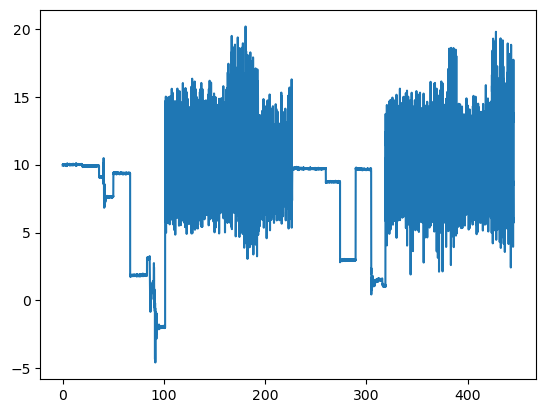

In [2]:
acc, actid, t, fs = getRawAcceleration(SubjectID=1, Component='x')
plt.plot(t, acc)
plt.show()

数据的更多细节
标签和颜色区分不同数据的样式

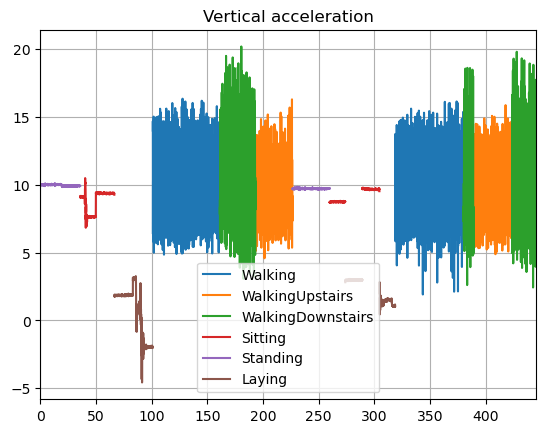

In [3]:
plotAccelerationColouredByActivity(t, acc, actid, 'Vertical acceleration')

使用频率来度量区分
比如说步行和平躺

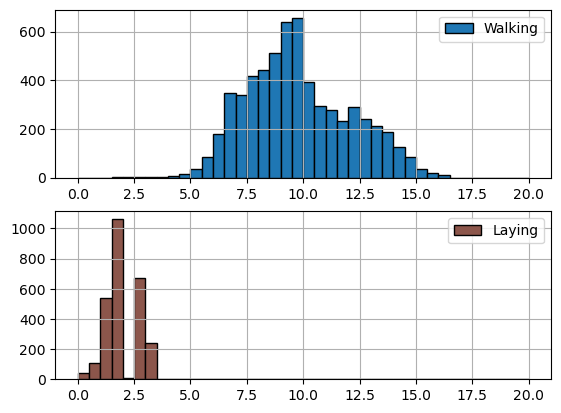

In [4]:
plotCompareHistForActivities(acc, actid,'Walking', 'Laying')

步行和站立

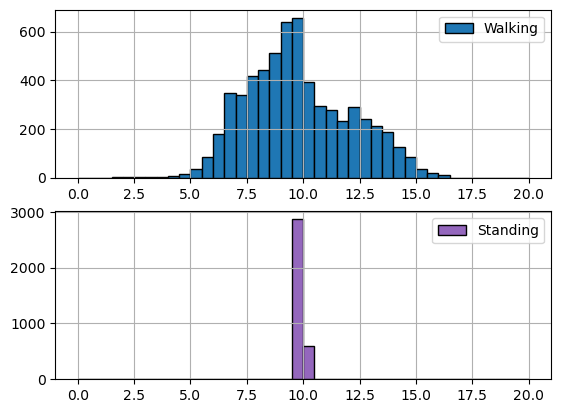

In [5]:
plotCompareHistForActivities(acc, actid, 'Walking', 'Standing')

仅频率方法通常是不够的
无法区分步行和上楼

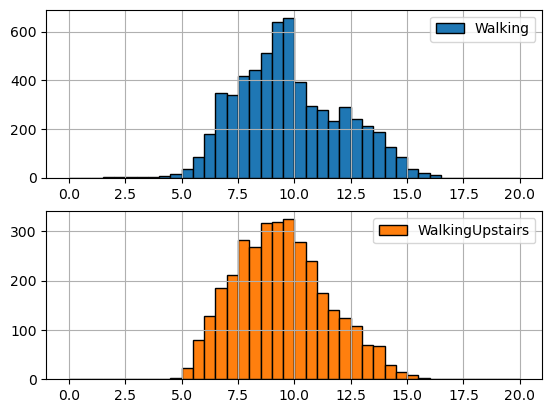

In [6]:
plotCompareHistForActivities(acc, actid, 'Walking', 'WalkingUpstairs')

做一下滤波 去除重力影响 做对比

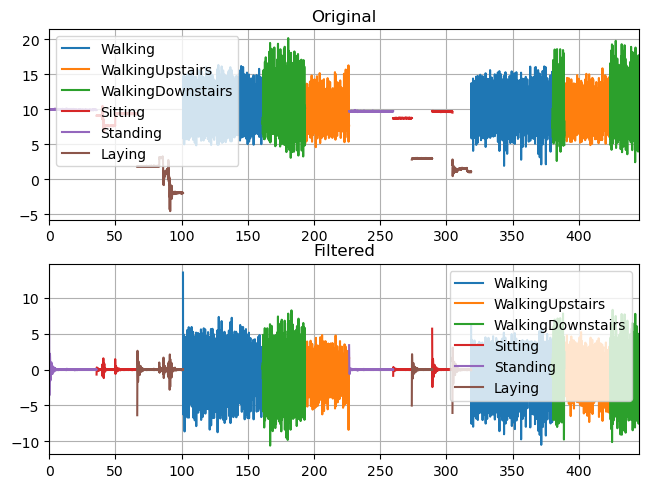

In [7]:
sos = hpfilter()
ab = signal.sosfilt(sos, acc)

plotAccelerationColouredByActivity2(t, acc, ab, actid, 'Original', 'Filtered')

现在先看看其中一种活动：行走 提取0-250s范围之间的标签为'Walking'图像

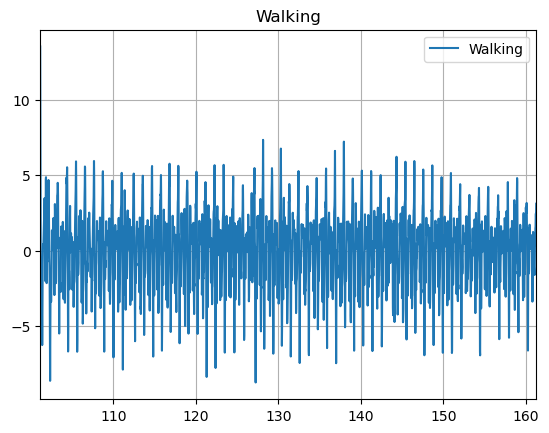

In [8]:
Walking = 1
ls = [x for x in [i for i, l in enumerate(actid) if l == Walking] if t[x] < 250]
tw = [t[x] for x in ls]
abw = [ab[x] for x in ls]
plotAccelerationColouredByActivity(tw, abw, actid, 'Walking')
plt.show()

行走运动下功率谱密度绘制

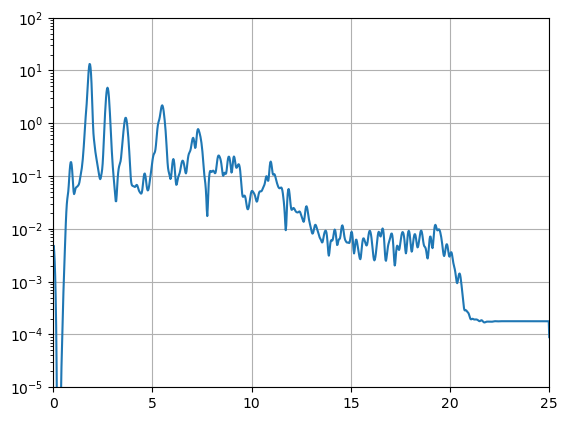

In [9]:
f, Pxx = signal.welch(abw, fs, nperseg=512, nfft=2048, return_onesided=True)
plt.semilogy(f, Pxx)
plt.xlim(0, 25)
plt.ylim(10 ** -5, 10 ** 2)
plt.grid()
plt.show()

验证PSD用于区分不同运动状况的可能性

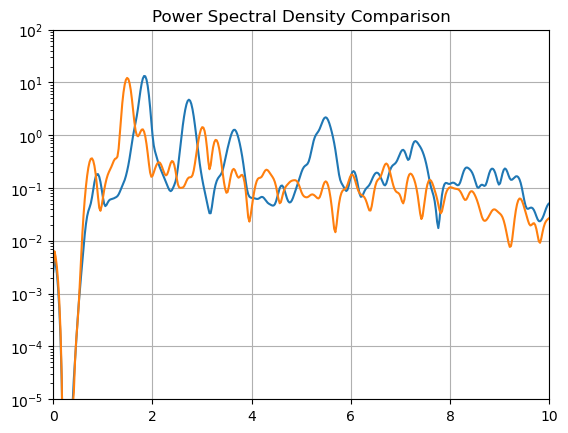

In [10]:
plotPSDActivityComparisonForSubject(1, 'Walking', 'WalkingUpstairs')

验证不同比例尺(不取对数)的 PSD 信息的一致性


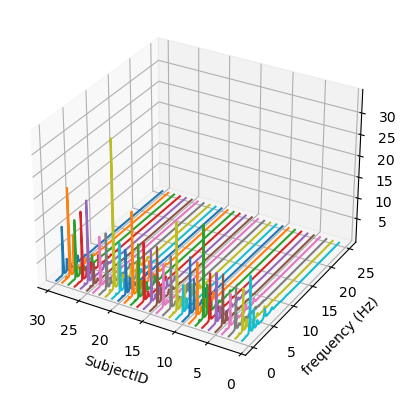

In [11]:
plotPSDForGivenActivity('Walking')

峰值寻找，峰值估计功率谱密度

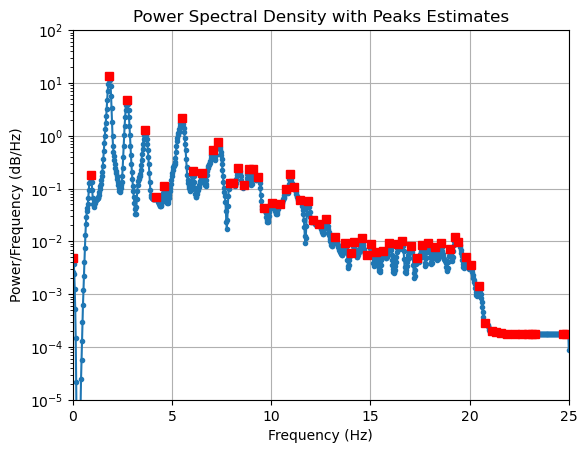

In [12]:
plt.semilogy(f, Pxx, '.-')
peaks, _ = signal.find_peaks(Pxx)
plt.plot(f[peaks], Pxx[peaks], 'rs')
plt.xlim(0, 25)
plt.ylim(10 ** -5, 10 ** 2)
plt.title('Power Spectral Density with Peaks Estimates')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.show()


优化查找频率功率谱密度峰值（相对于上一个）

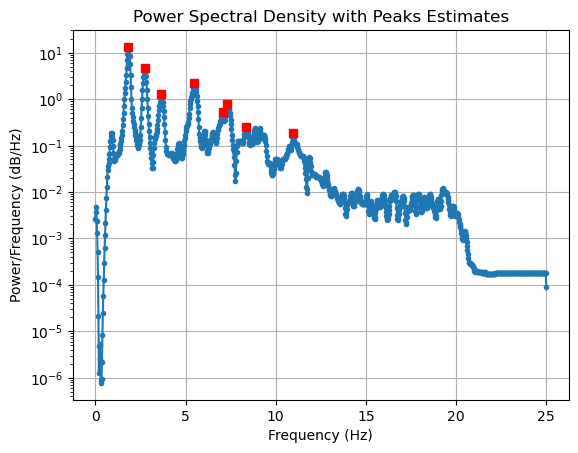

In [13]:
fdist = 0.25  # 最小距离（赫兹）
N = 2 * (len(f) - 1)
dist = np.floor(fdist / (fs / N))
plt.semilogy(f, Pxx, '.-')
peaks, _ = signal.find_peaks(Pxx, distance=dist, prominence=0.15)
plt.plot(f[peaks], Pxx[peaks], 'rs')
plt.title('Power Spectral Density with Peaks Estimates')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.show()

自相关也可以用于频率估计。它对估计低频基波频率特别有效

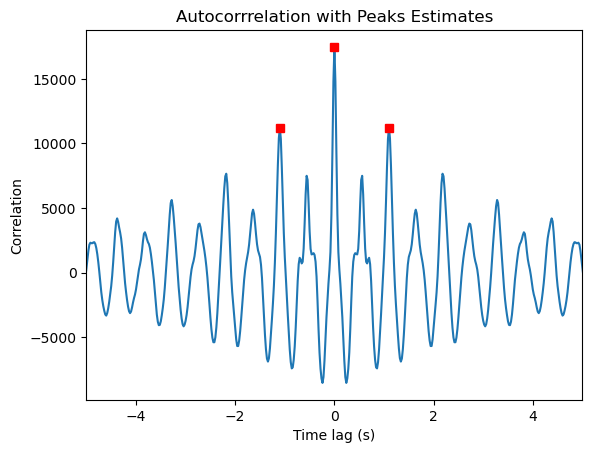

In [14]:
corr = signal.correlate(abw, abw)
lags = signal.correlation_lags(len(abw), len(abw))
tc = (1/fs)*lags
plt.plot(tc, corr)
tdist = 0.3
dist = np.floor(tdist/(1/fs))
peaks, _ = signal.find_peaks(corr, distance=dist, prominence=2e4-5e3, height=(0, None))
plt.plot(tc[peaks], corr[peaks], 'rs')
plt.xlim(-5,5)
plt.title('Autocorrrelation with Peaks Estimates')
plt.xlabel('Time lag (s)')
plt.ylabel('Correlation')
plt.show()

不同运动状态会导致主峰t=0差距很大

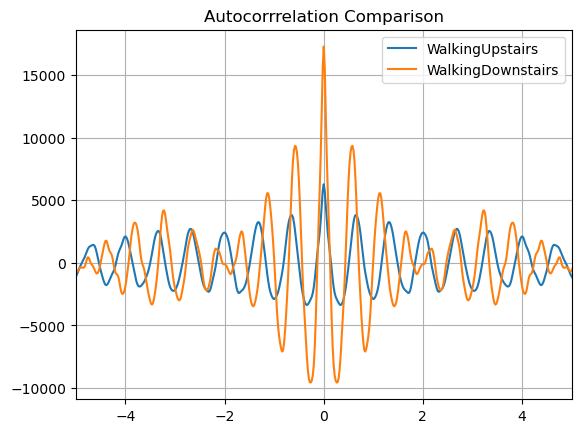

In [15]:
plotCorrActivityComparisonForSubject(1, 'WalkingUpstairs', 'WalkingDownstairs')